# GARMIN GPX FILE FOR TARGET HEART RATE & CYCLING VARIABLES
---
---

In [1]:
# Lesson 5.02 Webscraping
# https://towardsdatascience.com/data-science-for-cycling-how-to-read-gpx-strava-routes-with-python-e45714d5da23
# https://stackoverflow.com/questions/54873868/python-calculate-bearing-between-two-lat-long
# https://geographiclib.sourceforge.io/html/python/code.html#geographiclib.geodesic.Geodesic.AZIMUTH
# https://www.python-graph-gallery.com/43-use-categorical-variable-to-color-scatterplot-seaborn

# Imports
---

In [2]:
import pandas as pd
from pandas import json_normalize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time

# GPX file
import gpxpy
import gpxpy.gpx

# GPX file
from bs4 import BeautifulSoup
import lxml

# bearing
from geographiclib.geodesic import Geodesic

# distance
import haversine as hs

%matplotlib inline
pd.set_option('display.max_columns', None)

import warnings
warnings.simplefilter("ignore")

# Function gpx_to_df()
---

In [3]:
def gpx_to_df(filepath):
    
    # Open .gpx file and parse xml
    with open(filepath, 'r') as gpx_file:
        gpx = gpxpy.parse(gpx_file)
    
    # check file
    print(f'File: {filepath}')
    # check length of tracks
    print(f'Tracks: {len(gpx.tracks)}')
    # check number of data points
    print(f'No. of Track Points: {gpx.get_track_points_no()}')
    
    # extract timestamp, lat, lon, and elevation from gpx file
    route_info = []

    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                route_info.append({
                    'timestamp': point.time,
                    'latitude': point.latitude,
                    'longitude': point.longitude,
                    'elevation': point.elevation,
                })
    
    # create dataframe
    route_df = pd.DataFrame(route_info)
    # create UNIX column for later
    # https://statisticsglobe.com/convert-datetime-to-unix-timestamp-python
    route_df['dt'] = route_df['timestamp'].apply(lambda z: int(datetime.datetime.timestamp(z)))
    
    #######################
    # HEART RATE AND CADENCE
    # HAD TO REMOVE CADENCE FROM EXCUTED CODES DUE TO DATA FROM EARLIER THIS YEAR NOT HAVING THE SENSOR
    # add extension data with beautifulsoup
    xml = gpx.to_xml()
    soup = BeautifulSoup(xml, features = 'xml')
    
    # Use Beautiful Soup to find all heart rate and cadence
    hr_soup = soup.find_all('ns3:hr')
    cad_soup = soup.find_all('ns3:cad')
    
    # chop off early points from index - accounts for before cadence sensor calibration
    route_df = route_df[-len(cad_soup):]

    # for loop to extract heart rate and cadence values from each point
    hr_list = []
    cad_list = []
    for i in hr_soup:
        # https://stackoverflow.com/questions/69420686/bs4-element-resultset-elements-to-a-list
        hr_list.append(i.get_text(strip = True))

    for j in cad_soup:
        cad_list.append(j.get_text(strip = True))

    # add columns to dataset from extraction
    route_df['heart_rate'] = hr_list[-len(cad_soup):]
    route_df['cadence'] = cad_list
    
    #######################
    # BEARING
    # get_bearing function
    def get_bearing(lat1, lat2, long1, long2):
        brng = Geodesic.WGS84.Inverse(lat1, long1, lat2, long2)['azi1']
        return brng
    
    # assign bearing in df
    route_df['bearing'] = 0
    for i in range(1, len(route_df)):
        lat1 = route_df.latitude.iloc[i-1]
        lat2 = route_df.latitude.iloc[i]
        long1 = route_df.longitude.iloc[i-1]
        long2 = route_df.longitude.iloc[i]
        bearing = get_bearing(lat1, lat2, long1, long2)
        # https://stats.stackexchange.com/questions/283572/using-iloc-to-set-values
        route_df.bearing.iloc[[i]] = bearing
    
    ########################    
    # ELAPSED TIME - SECONDS
    route_df['timestamp'] = pd.to_datetime(route_df['timestamp'])
    route_df['time_diff_s'] = 0
    for i in range(1, len(route_df)-1):
        t1 = route_df.iloc[i]['timestamp']
        t2 = route_df.iloc[i-1]['timestamp']
        # https://www.geeksforgeeks.org/how-to-set-cell-value-in-pandas-dataframe/
        route_df.at[i, 'time_diff_s'] = (t1 - t2).seconds
    route_df['total_time_s'] = route_df['time_diff_s'].cumsum(skipna = True)
    
    #######################
    # ELEVATION CHANGE - METERS
    route_df['ele_diff_m'] = 0
    for i in range(1, len(route_df)-1):
        e1 = route_df.iloc[i]['elevation']
        e2 = route_df.iloc[i-1]['elevation']
        route_df.at[i, 'ele_diff_m'] = (e1 - e2)
    route_df['total_ele_change_m'] = round(route_df['ele_diff_m'].cumsum(skipna = True), 4)
    
    #######################
    # DISTANCE - KILOMETERS
    route_df['lat_lon'] = [(lat, lon) for lat, lon in zip(route_df['latitude'], route_df['longitude'])]
    route_df['dist_diff_km'] = 0
    for i in range(1, len(route_df)-1):
        loc1 = route_df.iloc[i]['lat_lon']
        loc2 = route_df.iloc[i-1]['lat_lon']
        route_df.at[i, 'dist_diff_km'] = round(hs.haversine(loc1, loc2), 4) # kilometers
    route_df['total_dist_km'] = route_df['dist_diff_km'].cumsum(skipna = True)
    
   
    #######################
    route_df.reset_index(drop = True, inplace = True)
    
    return route_df

In [4]:
gpx_to_df('../data/sandbox/a_1728.gpx').head()

File: ../data/sandbox/a_1728.gpx
Tracks: 1
No. of Track Points: 2224


,timestamp,latitude,longitude,elevation,dt,heart_rate,cadence,bearing,time_diff_s,total_time_s,ele_diff_m,total_ele_change_m,lat_lon,dist_diff_km,total_dist_km
0,2022-08-06 20:32:03+00:00,38.631716,-121.237873,30.799999,1.659818e+09,83,84,0.000000,3.0,3.0,0.000000,0.0,"(38.631715876981616, -121.237873127684)",0.0215,0.0215
1,2022-08-06 20:32:04+00:00,38.631710,-121.237949,30.200001,1.659818e+09,82,82,-95.964326,3.0,6.0,0.000000,0.0,"(38.63170967437327, -121.23794881626964)",0.0215,0.0430
2,2022-08-06 20:32:08+00:00,38.631667,-121.238385,31.000000,1.659818e+09,81,80,-97.059499,4.0,10.0,0.200001,0.2,"(38.63166726194322, -121.23838542960584)",0.0272,0.0702
3,2022-08-06 20:32:11+00:00,38.631642,-121.238631,31.000000,1.659818e+09,84,80,-97.380397,3.0,13.0,-0.200001,0.0,"(38.63164228387177, -121.23863127082586)",0.0208,0.0910
4,2022-08-06 20:32:14+00:00,38.631620,-121.238877,31.000000,1.659818e+09,83,78,-96.586353,1.0,14.0,0.000000,0.0,"(38.631619988009334, -121.23887744732201)",0.0067,0.0977


# Build Out of gpx_to_df()
---

## Garmin GPX File

In [5]:
# Open .gpx file and parse xml
with open('../data/sandbox/a_1728.gpx', 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

In [6]:
# check length of tracks
print(f'Tracks: {len(gpx.tracks)}')
# check number of data points
print(f'No. of Track Points: {gpx.get_track_points_no()}')

Tracks: 1
No. of Track Points: 2224


In [7]:
# explore
moving_data = gpx.get_moving_data(raw=True)
moving_data

MovingData(moving_time=7695.0, stopped_time=1716.0, moving_distance=50185.249780327096, stopped_distance=32.91609145123523, max_speed=12.599254176519333)

In [8]:
gpx.get_uphill_downhill()

UphillDownhill(uphill=245.40001077651982, downhill=229.20001192092926)

In [9]:
gpx.extensions

[]

### Pull Data from GPX

In [10]:
# check out .gpx file as xml
# gpx.to_xml()[:2000]

In [11]:
# extract timestamp, lat, lon, and elevation from gpx file
test_info = []

for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            test_info.append({
                'timestamp': point.time,
                'latitude': point.latitude,
                'longitude': point.longitude,
                'elevation': point.elevation,
            })

In [12]:
test = pd.DataFrame(test_info)

In [13]:
test.head()

,timestamp,latitude,longitude,elevation
0,2022-08-06 20:31:59+00:00,38.631832,-121.237544,31.600000
1,2022-08-06 20:32:01+00:00,38.631761,-121.237665,31.200001
2,2022-08-06 20:32:02+00:00,38.631722,-121.237779,31.000000
3,2022-08-06 20:32:03+00:00,38.631716,-121.237873,30.799999
4,2022-08-06 20:32:04+00:00,38.631710,-121.237949,30.200001


## BeautifulSoup for Extension Data - heartrate, cadence

In [14]:
xml = gpx.to_xml()
soup = BeautifulSoup(xml, features = 'xml')

In [15]:
time_soup = soup.find_all('time')
hr_soup = soup.find_all('ns3:hr')
cad_soup = soup.find_all('ns3:cad')

In [16]:
# type(time_soup)

In [17]:
# len(time_soup)

In [18]:
# type(hr_soup)

In [19]:
# len(hr_soup)

In [20]:
# len(soup.find_all('ns3:hr')[-len(cad_soup):])

In [21]:
# len(cad_soup)

In [22]:
# len(route_df)

In [23]:
# chop off early points from index - accounts for before cadence sensor calibration
test = test[-len(cad_soup):]

# for loop to extract heart rate and cadence values from each point
hr_list = []
cad_list = []
for i in hr_soup:
    hr_list.append(i.get_text(strip = True))
    
for j in cad_soup:
    cad_list.append(j.get_text(strip = True))

In [24]:
# add columns to dataset from extraction
test['heart_rate'] = hr_list[-len(cad_soup):]
test['cadence'] = cad_list

In [25]:
test.head()

,timestamp,latitude,longitude,elevation,heart_rate,cadence
3,2022-08-06 20:32:03+00:00,38.631716,-121.237873,30.799999,83,84
4,2022-08-06 20:32:04+00:00,38.631710,-121.237949,30.200001,82,82
5,2022-08-06 20:32:08+00:00,38.631667,-121.238385,31.000000,81,80
6,2022-08-06 20:32:11+00:00,38.631642,-121.238631,31.000000,84,80
7,2022-08-06 20:32:14+00:00,38.631620,-121.238877,31.000000,83,78


## Create Bearing Column

In [26]:
def get_bearing(lat1, lat2, long1, long2):
    brng = Geodesic.WGS84.Inverse(lat1, long1, lat2, long2)['azi1']
    return brng

In [27]:
get_bearing(38.773795, 38.773860, -121.363652, -121.363689)

-24.017929532262528

In [28]:
test['bearing'] = 0
for i in range(1, len(test)):
    lat1 = test.latitude.iloc[i-1]
    lat2 = test.latitude.iloc[i]
    long1 = test.longitude.iloc[i-1]
    long2 = test.longitude.iloc[i]
    bearing = get_bearing(lat1, lat2, long1, long2)
    # https://stats.stackexchange.com/questions/283572/using-iloc-to-set-values
    test.bearing.iloc[[i]] = bearing

In [29]:
#test.head(10)

## Create Distance Column

In [30]:
test['lat_lon'] = [(lat, lon) for lat, lon in zip(test['latitude'], test['longitude'])]

In [31]:
test['dist_diff_km'] = 0
for i in range(1, len(test)-1):
    loc1 = test.iloc[i]['lat_lon']
    loc2 = test.iloc[i-1]['lat_lon']
    test.at[i, 'dist_diff_km'] = hs.haversine(loc1, loc2) # kilometers
test['total_dist_km'] = test['dist_diff_km'].cumsum(skipna = True)

In [32]:
test.dropna(inplace = True)
test

,timestamp,latitude,longitude,elevation,heart_rate,cadence,bearing,lat_lon,dist_diff_km,total_dist_km
3,2022-08-06 20:32:03+00:00,38.631716,-121.237873,30.799999,83,84,0.000000,"(38.631715876981616, -121.237873127684)",0.021534,0.021534
4,2022-08-06 20:32:04+00:00,38.631710,-121.237949,30.200001,82,82,-95.964326,"(38.63170967437327, -121.23794881626964)",0.021527,0.043061
5,2022-08-06 20:32:08+00:00,38.631667,-121.238385,31.000000,81,80,-97.059499,"(38.63166726194322, -121.23838542960584)",0.027186,0.070247
6,2022-08-06 20:32:11+00:00,38.631642,-121.238631,31.000000,84,80,-97.380397,"(38.63164228387177, -121.23863127082586)",0.020846,0.091092
7,2022-08-06 20:32:14+00:00,38.631620,-121.238877,31.000000,83,78,-96.586353,"(38.631619988009334, -121.23887744732201)",0.006680,0.097772
...,...,...,...,...,...,...,...,...,...,...
2219,2022-08-06 23:08:35+00:00,38.631991,-121.229837,49.200001,162,0,115.803567,"(38.63199113868177, -121.22983697801828)",0.000661,50.070298
2220,2022-08-06 23:08:41+00:00,38.631968,-121.229655,49.400002,160,3,99.354210,"(38.63196766935289, -121.22965534217656)",0.000000,50.070298
2221,2022-08-06 23:08:45+00:00,38.631964,-121.229644,48.599998,158,3,109.087663,"(38.631964484229684, -121.22964360751212)",0.000000,50.070298
2222,2022-08-06 23:08:48+00:00,38.631960,-121.229639,48.000000,157,0,143.383900,"(38.631959706544876, -121.2296390812844)",0.000000,50.070298


In [33]:
test = gpx_to_df('../data/sandbox/a_1728.gpx')

File: ../data/sandbox/a_1728.gpx
Tracks: 1
No. of Track Points: 2224


In [34]:
test.to_csv('../data/sandbox/a_1728.csv', index = False)

# Plot

<Figure size 1152x576 with 0 Axes>

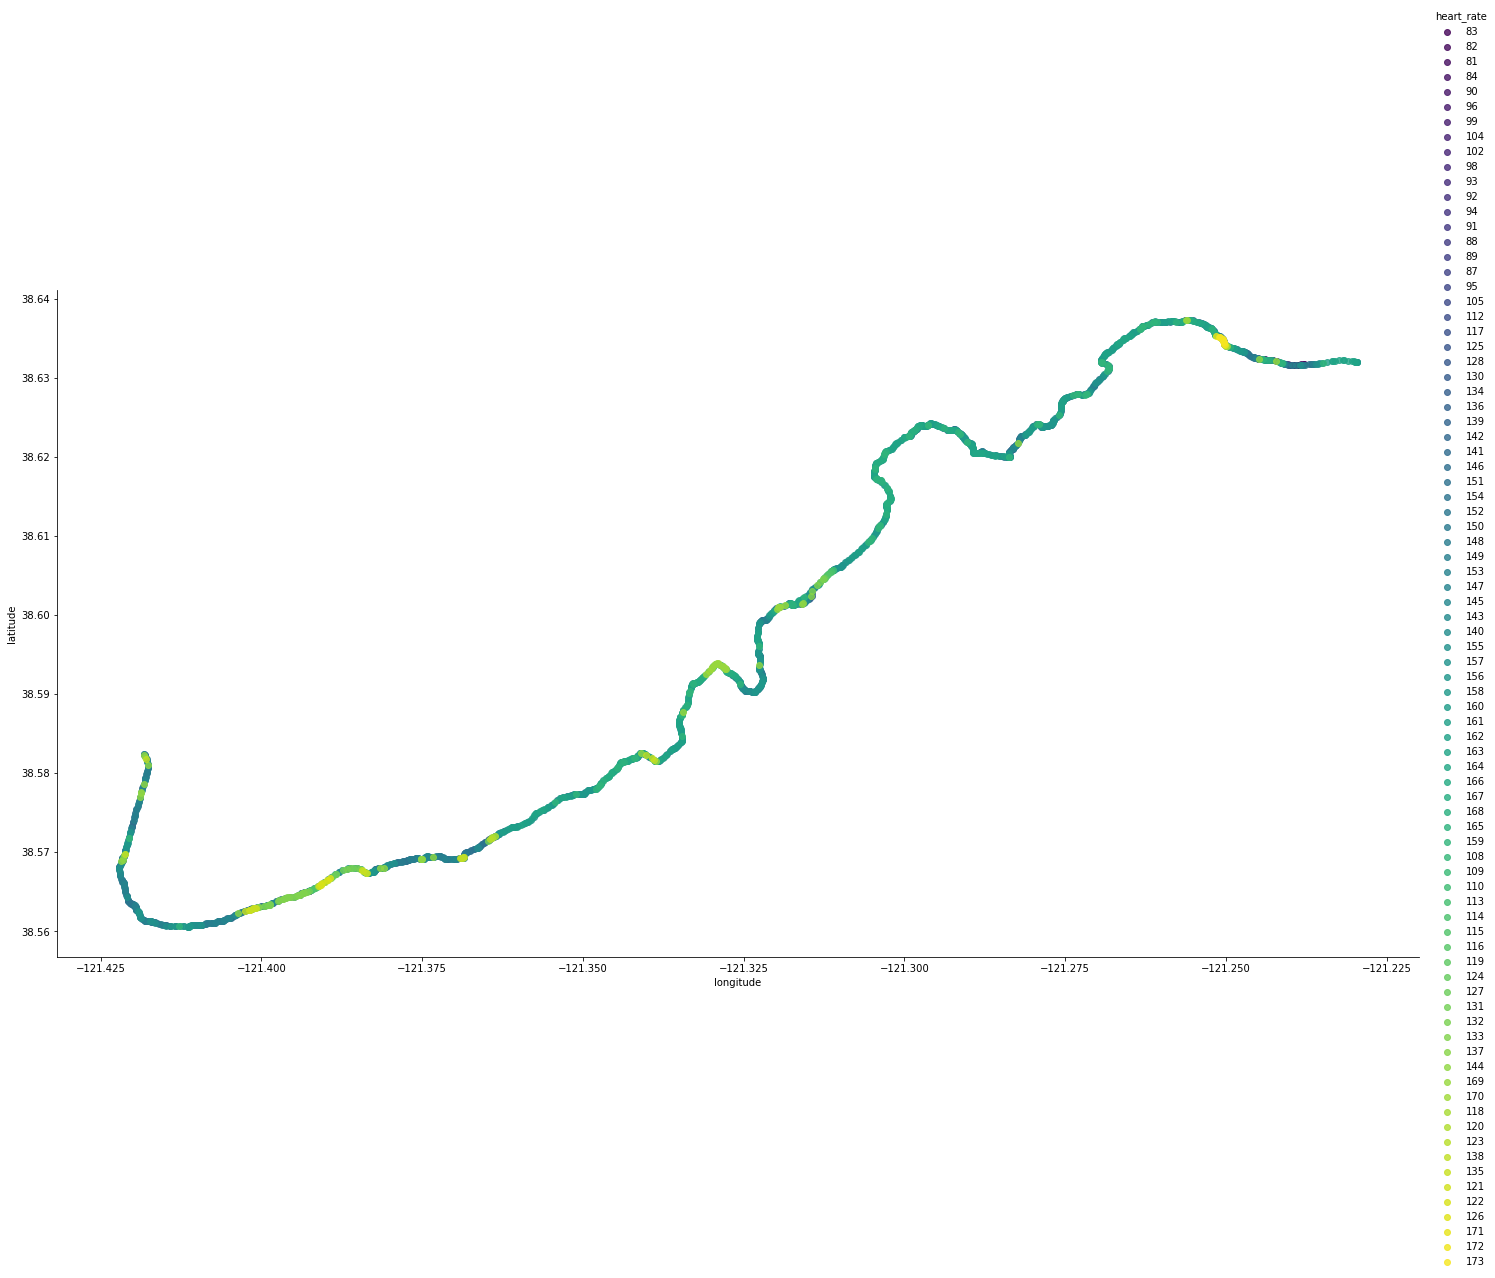

In [35]:
# Use the 'hue' argument to provide a factor variable
plt.figure(figsize = (16, 8))
sns.lmplot( x="longitude", y="latitude", data=test, fit_reg=False, 
           hue='heart_rate', 
           palette = 'viridis', 
           height = 10, aspect = 2)

plt.show();